In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sentence_transformers import SentenceTransformer
warnings.filterwarnings('ignore')
from huggingface_hub import hf_hub_download
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


In [81]:
df = pd.read_csv("Data\imdb_top_1000.csv")

In [82]:
df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [83]:
print(df.shape)
print(df.info())

(1000, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB
None


In [84]:
df.isnull().sum()

Poster_Link        0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

In [85]:
cat_clms = df.select_dtypes(include = 'object').columns
num_clms = df.select_dtypes(include = 'number').columns
print(cat_clms,len(cat_clms))
print(num_clms,len(num_clms))

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'Overview', 'Director', 'Star1', 'Star2', 'Star3',
       'Star4', 'Gross'],
      dtype='object') 13
Index(['IMDB_Rating', 'Meta_score', 'No_of_Votes'], dtype='object') 3


In [86]:
df['Meta_score'] = df['Meta_score'].fillna(df['Meta_score'].mean())
df['Gross'] = df['Gross'].replace(',', '', regex=True).astype(float)
df['Gross'] = df['Gross'].fillna(df['Gross'].median())
df['Certificate'] = df['Certificate'].fillna("Unknown",inplace = True)

In [87]:
df['Released_Year'] = pd.to_numeric(df['Released_Year'],errors='coerce')
df['Runtime'] = df['Runtime'].str.replace('min', '').astype(float)

In [88]:
df['Tags'] = df['Genre'] + " " + df['Director'] + " " + \
             df['Star1'] + " " + df['Star2'] + " " + \
             df['Star3'] + " " + df['Star4'] + df['Overview']


In [89]:
df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Tags
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994.0,None,142.0,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0,Drama Frank Darabont Tim Robbins Morgan Freema...
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972.0,None,175.0,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,"Crime, Drama Francis Ford Coppola Marlon Brand..."
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008.0,None,152.0,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,"Action, Crime, Drama Christopher Nolan Christi..."
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974.0,None,202.0,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0,"Crime, Drama Francis Ford Coppola Al Pacino Ro..."
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957.0,None,96.0,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0,"Crime, Drama Sidney Lumet Henry Fonda Lee J. C..."


In [90]:
model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')

In [91]:
embeddings = model.encode(df['Tags'].tolist(), show_progress_bar=True)
df['embeddings'] = list(embeddings)

Batches: 100%|██████████| 32/32 [00:10<00:00,  3.08it/s]


In [92]:
df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Tags,embeddings
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994.0,None,142.0,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0,Drama Frank Darabont Tim Robbins Morgan Freema...,"[-0.11711403, -0.027513167, -0.06513245, -0.01..."
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972.0,None,175.0,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,"Crime, Drama Francis Ford Coppola Marlon Brand...","[-0.09540948, -0.04333323, -0.07150438, -0.050..."
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008.0,None,152.0,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,"Action, Crime, Drama Christopher Nolan Christi...","[-0.012059909, 0.009306627, -0.11053509, -0.01..."
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974.0,None,202.0,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0,"Crime, Drama Francis Ford Coppola Al Pacino Ro...","[-0.07844472, -0.01384951, -0.06736454, -0.053..."
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957.0,None,96.0,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0,"Crime, Drama Sidney Lumet Henry Fonda Lee J. C...","[-0.11382514, 0.034777734, -0.082070924, -0.01..."


In [93]:
X = np.vstack(df['embeddings'].values)
print(X.shape)

(1000, 384)


In [94]:
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X)

df['cluster'] = labels
df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Tags,embeddings,cluster
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994.0,None,142.0,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0,Drama Frank Darabont Tim Robbins Morgan Freema...,"[-0.11711403, -0.027513167, -0.06513245, -0.01...",1
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972.0,None,175.0,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,"Crime, Drama Francis Ford Coppola Marlon Brand...","[-0.09540948, -0.04333323, -0.07150438, -0.050...",1
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008.0,None,152.0,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,"Action, Crime, Drama Christopher Nolan Christi...","[-0.012059909, 0.009306627, -0.11053509, -0.01...",1
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974.0,None,202.0,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0,"Crime, Drama Francis Ford Coppola Al Pacino Ro...","[-0.07844472, -0.01384951, -0.06736454, -0.053...",1
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957.0,None,96.0,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0,"Crime, Drama Sidney Lumet Henry Fonda Lee J. C...","[-0.11382514, 0.034777734, -0.082070924, -0.01...",1


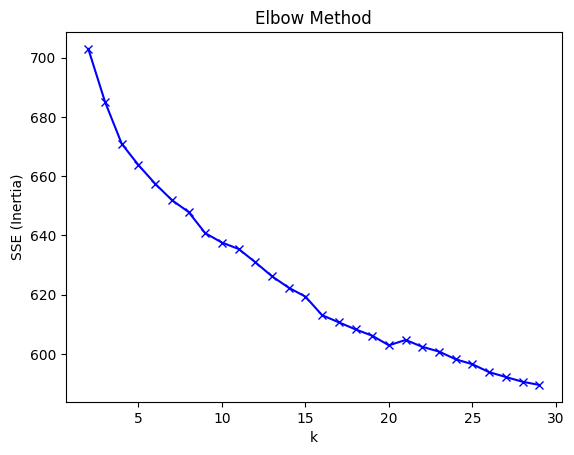

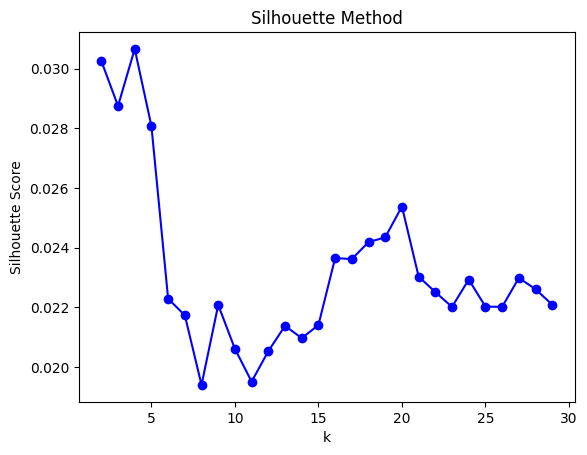

In [95]:
sse = []
silhouette_scores = []
K = range(2, 30)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)  # Sum of squared errors
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method')
plt.show()

# Plot Silhouette Scores
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

In [96]:
best_k = 6  # for example
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

print(df[['Tags', 'cluster']].head())

                                                Tags  cluster
0  Drama Frank Darabont Tim Robbins Morgan Freema...        1
1  Crime, Drama Francis Ford Coppola Marlon Brand...        5
2  Action, Crime, Drama Christopher Nolan Christi...        5
3  Crime, Drama Francis Ford Coppola Al Pacino Ro...        1
4  Crime, Drama Sidney Lumet Henry Fonda Lee J. C...        1


In [97]:
def recommend_by_cluster(movie_Series_Title, n_recs=5):
    # Find cluster of the given movie
    movie_cluster = df.loc[df['Series_Title'] == movie_Series_Title, 'cluster'].values[0]
    
    # Get movies from the same cluster
    cluster_movies = df[df['cluster'] == movie_cluster]
    
    # Exclude the original movie and return top N
    recs = cluster_movies[cluster_movies['Series_Title'] != movie_Series_Title].sample(n=n_recs, random_state=42)
    return recs[['Series_Title', 'Tags', 'cluster']]

In [98]:
def recommend_by_similarity(movie_Series_Title, n_recs=5):
    # Find index of the given movie
    idx = df.index[df['Series_Title'] == movie_Series_Title][0]
    
    # Get similarity scores for that movie
    sim_scores = list(enumerate(similarity_matrix[idx]))
    
    # Sort by similarity (highest first, skip itself)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n_recs+1]
    
    # Get recommended movies
    recs = df.iloc[[i[0] for i in sim_scores]]
    return recs[['Series_Title', 'Tags', 'cluster']]

In [99]:
df.head()


,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Tags,embeddings,cluster
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994.0,None,142.0,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0,Drama Frank Darabont Tim Robbins Morgan Freema...,"[-0.11711403, -0.027513167, -0.06513245, -0.01...",1
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972.0,None,175.0,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,"Crime, Drama Francis Ford Coppola Marlon Brand...","[-0.09540948, -0.04333323, -0.07150438, -0.050...",5
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008.0,None,152.0,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,"Action, Crime, Drama Christopher Nolan Christi...","[-0.012059909, 0.009306627, -0.11053509, -0.01...",5
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974.0,None,202.0,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0,"Crime, Drama Francis Ford Coppola Al Pacino Ro...","[-0.07844472, -0.01384951, -0.06736454, -0.053...",1
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957.0,None,96.0,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0,"Crime, Drama Sidney Lumet Henry Fonda Lee J. C...","[-0.11382514, 0.034777734, -0.082070924, -0.01...",1


In [102]:
recommend_by_cluster("On the Waterfront", n_recs=5)


,Series_Title,Tags,cluster
257,La haine,"Crime, Drama Mathieu Kassovitz Vincent Cassel ...",5
299,Les quatre cents coups,"Crime, Drama François Truffaut Jean-Pierre Léa...",5
22,Cidade de Deus,"Crime, Drama Fernando Meirelles Kátia Lund Ale...",5
351,Yip Man,"Action, Biography, Drama Wilson Yip Donnie Yen...",5
161,"Lock, Stock and Two Smoking Barrels","Action, Comedy, Crime Guy Ritchie Jason Flemyn...",5
